# Single Object Detector

The notebook illustrates how this synthetic data generator can help to create and test a single object detector.

**Please note that the goal of this notebook is not to create the perfect ML model, but to demonstrate how to use the functionality of this library.**

In [1]:
import sys
sys.path.insert(0, '..')

from PIL import ImageDraw
import tensorflow as tf
import numpy as np

from squids import (
    create_dataset,
    create_tfrecords,
    explore_tfrecords,
    load_tfrecords,
    Palette,
    Background
)

from helper import plot_images

## Preparing Dataset

Generate synthetic dataset and convert it to TFRecords.

In [2]:
create_dataset(
    dataset_size=10000,
    image_palette=Palette.BINARY,
    image_background=Background.BLACK,
    random_state=365, image_capacity=1,
    verbose=True)
create_tfrecords(
    verbose=True)

100%|██████████| 999/999 [00:00<00:00, 1217.78it/s]


Explore 9 samples from the generated dataset.

2022-02-15 10:14:51.605481: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-15 10:14:51.647185: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-15 10:14:51.647415: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-15 10:14:51.648117: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

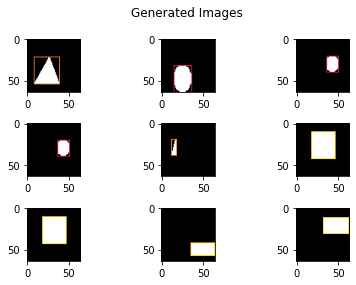

In [3]:
image_ids, _ = explore_tfrecords(
    'dataset/synthetic-tfrecords/instances_train',
    return_artifacts=True
)

images  = [
    explore_tfrecords(
        'dataset/synthetic-tfrecords/instances_train',
        image_id,
        with_categories = False,
        with_bboxes = True,
        with_segmentations = False,
        return_artifacts=True
    )[0]
    for image_id in image_ids[0:10]
]

plot_images(images, "Generated Images")

## Train Object Detection Model

Let's create generators for train and validation datasets and compute steps per epoch for each of them.

In [4]:
import pathlib

ds_train, train_steps_per_epoch = load_tfrecords(
    pathlib.Path("dataset/synthetic-tfrecords/instances_train"), 
    output_schema = "B",
    num_detecting_objects=1,
    batch_size=128
)
print("Training steps per epoch (for the batch size 128): ", train_steps_per_epoch)

ds_val, val_steps_per_epoch = load_tfrecords(
    pathlib.Path("dataset/synthetic-tfrecords/instances_val"), 
    output_schema = "B",
    num_detecting_objects=1,
    batch_size=128
)
print("Validation steps per epoch (for the batch size 128): ", val_steps_per_epoch)

2022-02-15 10:15:09.618834: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled


Training steps per epoch (for the batch size 128):  55
Validation steps per epoch (for the batch size 128):  16


Let's define a simple convolution model.

In [5]:
model = tf.keras.models.Sequential([
	tf.keras.layers.Conv2D(
			filters=32,
            kernel_size=(3, 3),
            padding='same',
            input_shape=(64, 64, 3)),
	tf.keras.layers.Flatten(),
	tf.keras.layers.Dense(
		1024, 
		kernel_initializer='random_normal',
		bias_initializer='zeros',
		activation='relu'),
	tf.keras.layers.Dense(
		4,
		activation='relu')
])
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.MeanAbsoluteError(),
)

Train the model.

In [9]:
model.fit(
    ds_train,
    steps_per_epoch = train_steps_per_epoch,
    epochs=10,
    validation_data=ds_val,
    validation_steps = val_steps_per_epoch,
    verbose=1
)

Epoch 1/10
55/55 [==============================] - 5s 94ms/step - loss: 0.8751 - val_loss: 1.6050
Epoch 2/10
55/55 [==============================] - 5s 96ms/step - loss: 0.8434 - val_loss: 1.5978
Epoch 3/10
55/55 [==============================] - 5s 99ms/step - loss: 0.8052 - val_loss: 1.6504
Epoch 4/10
55/55 [==============================] - 5s 96ms/step - loss: 0.7692 - val_loss: 1.5459
Epoch 5/10
55/55 [==============================] - 5s 100ms/step - loss: 0.7123 - val_loss: 1.5602
Epoch 6/10
55/55 [==============================] - 6s 107ms/step - loss: 0.6850 - val_loss: 1.5167
Epoch 7/10
55/55 [==============================] - 6s 109ms/step - loss: 0.6829 - val_loss: 1.5223
Epoch 8/10
55/55 [==============================] - 6s 106ms/step - loss: 0.6391 - val_loss: 1.5022
Epoch 9/10
55/55 [==============================] - 6s 106ms/step - loss: 0.6482 - val_loss: 1.4708
Epoch 10/10
55/55 [==============================] - 6s 108ms/step - loss: 0.6902 - val_loss: 1.4786


## Test Object Detection Model

Let's test the model on the unseen data.

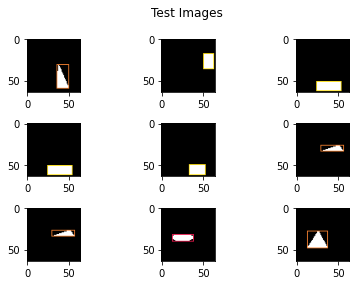

In [14]:
image_ids, _ = explore_tfrecords(
    'dataset/synthetic-tfrecords/instances_test',
    return_artifacts=True
)

images  = [
    explore_tfrecords(
        'dataset/synthetic-tfrecords/instances_test',
        image_id,
        with_categories = False,
        with_bboxes = True,
        with_segmentations = False,
        return_artifacts=True
    )[0]
    for image_id in image_ids[0:10]
]

plot_images(images, "Test Images")

Make model prediction and overlay results on the test images.

Predicted bounding boxes (x,y,w,h):
 [[32 31 14 25]
 [48 16 13 20]
 [23 50 31 13]
 [31 46 22 15]
 [30 24 22  8]
 [12 32 24  7]
 [10 22 24 22]
 [45 10 11 25]
 [16  2 25 23]
 [17  3 26 22]]


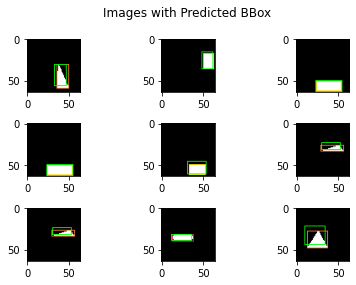

In [15]:
preprocessed_images = np.array(
    [np.array(image) for image in images]
) / 255.0

predicted_bboxes = model.predict(preprocessed_images).astype(int)

print("Predicted bounding boxes (x,y,w,h):\n", predicted_bboxes)


for image, bbox in zip(images, predicted_bboxes):
    draw = ImageDraw.Draw(image)
    draw.rectangle(
        (bbox[0], bbox[1], bbox[0]+bbox[2], bbox[1]+bbox[3]),
        outline="#00FF00"
    )

plot_images(images, "Images with Predicted BBox")